# Notebook to plot the helicity angles of $a_{0}$

In [26]:
import ROOT
import numpy as np
import my_library.common_analysis_tools as ct
import my_library.constants as constants
import my_library.kinematic_cuts as kcuts
import pandas as pd

In [27]:
def define_a0_helicity(channel, run_period, data_type, thrown=False, filtered=True):
    if data_type not in ['signal', 'data', 'phasespace']:
        return None

    if thrown: filtered=False
    df = ct.get_dataframe(channel, run_period, data_type, thrown=thrown, filtered=filtered)

    if not thrown:
        proton = 'p'
        if channel == 'pipkmks':
            pion = 'pip1'
            kaon = 'km'
        else:
            pion = 'pim1'
            kaon = 'kp'
    else: 
        proton = 'Proton'
        if channel == 'pipkmks':
            pion = 'PiPlus1'
            kaon = 'KMinus'
            ks = 'PiPlus2_{0} + PiMinus_{0}'
        else:
            pion = 'PiMinus1'
            kaon = 'KPlus'
            ks = 'PiMinus2_{0} + PiPlus_{0}'
        df = df.Define('ks_px', ks.format('px'))
        df = df.Define('ks_py', ks.format('py'))
        df = df.Define('ks_pz', ks.format('pz'))
        df = df.Define('ks_E', ks.format('E'))
        df = df.Define('ks_m', 'sqrt(ks_E*ks_E - ks_px*ks_px - ks_py*ks_py - ks_pz*ks_pz)')

    df = df.Define('kk_px', f'{kaon}_px + ks_px')
    df = df.Define('kk_py', f'{kaon}_py + ks_py')
    df = df.Define('kk_pz', f'{kaon}_pz + ks_pz')
    df = df.Define('kk_E', f'{kaon}_E + ks_E')
    df = df.Define("beam_p4", "ROOT::Math::PxPyPzEVector(e_beam, 0, 0, e_beam)")
    df = df.Define("target_p4", "ROOT::Math::PxPyPzEVector(0, 0, 0, 0.938272)")
    df = df.Define('cm_boost_vector', '(beam_p4 + target_p4).BoostToCM()')
    df = df.Define('p_p4', f'ROOT::Math::PxPyPzEVector({proton}_px, {proton}_py, {proton}_pz, {proton}_E)')
    df = df.Define(f'{channel}_p4', f'ROOT::Math::PxPyPzEVector({channel}_px, {channel}_py, {channel}_pz, {channel}_E)')
    df = df.Define('kk_p4', 'ROOT::Math::PxPyPzEVector(kk_px, kk_py, kk_pz, kk_E)')
    df = df.Define(f'{pion}_p4', f'ROOT::Math::PxPyPzEVector({pion}_px, {pion}_py, {pion}_pz, {pion}_E)')
    df = df.Define('cm_boost', "ROOT::Math::Boost(cm_boost_vector)")
    df = df.Define('p_p4_cm', 'cm_boost(p_p4)')
    df = df.Define(f'{channel}_p4_cm', f'cm_boost({channel}_p4)')
    df = df.Define('kk_p4_cm', 'cm_boost(kk_p4)')
    df = df.Define(f'{pion}_p4_cm', f'cm_boost({pion}_p4)')
    df = df.Define('beam_p4_cm', 'cm_boost(beam_p4)')
    df = df.Define('target_p4_cm', 'cm_boost(target_p4)')
    df = df.Define('f1_rest_boost_vector', f'{channel}_p4_cm.BoostToCM()')
    df = df.Define('f1_rest_boost', 'ROOT::Math::Boost(f1_rest_boost_vector)')
    df = df.Define('kk_p4_rest', 'f1_rest_boost(kk_p4_cm)')
    df = df.Define(f'{pion}_p4_rest', f'f1_rest_boost({pion}_p4_cm)')
    df = df.Define('yhat', f'beam_p4_cm.Vect().Cross({channel}_p4_cm.Vect()).Unit()')
    df = df.Define('zhat', f'{channel}_p4_cm.Vect().Unit()')
    df = df.Define('xhat', 'yhat.Cross(zhat)')
    df = df.Define('kk_rest_p3', 'kk_p4_rest.Vect()')
    df = df.Define('kk_helicty_p3', 'ROOT::Math::XYZVector(kk_rest_p3.Dot(xhat), kk_rest_p3.Dot(yhat), kk_rest_p3.Dot(zhat))')
    df = df.Define('kk_helicity_costheta', 'kk_helicty_p3.Z()/sqrt(kk_helicty_p3.Mag2())')

    return df

In [28]:
ROOT.EnableImplicitMT()
ROOT.gStyle.SetOptStat(0)

In [29]:
channel = 'pipkmks'
# channel = 'pimkpks'
run_period = 'spring'

if channel == 'pipkmks':
    cut = kcuts.KSTAR_ALL_CUT_PIPKMKS
elif channel == 'pimkpks':
    cut = kcuts.KSTAR_ALL_CUT_PIMKPKS

In [30]:
df_data = define_a0_helicity(channel, run_period, 'data').Filter(cut)
df_phasespace = define_a0_helicity(channel, run_period, 'phasespace').Filter(cut)
df_thrown = define_a0_helicity(channel, run_period, 'phasespace', thrown=True)


In [31]:
signal_region = f'{channel}_m < 1.35 && {channel}_m > 1.2'

x_low, x_high = -1.1, 1.1
nbin = int((x_high - x_low)/0.1)

hist_full_range_data = df_data.Filter(signal_region).Histo1D(('hist_full_range_data', 'Cos(#Theta_{H}) for 1.2 < M(KK#pi) < 1.35', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()
hist_full_range_phasespace = df_phasespace.Filter(signal_region).Histo1D(('hist_full_range_phasespace', 'hist_full_range_phasespace', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()
hist_full_range_thrown = df_thrown.Filter(signal_region).Histo1D(('hist_full_range_thrown', 'hist_full_range_thrown', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()



In [32]:
hist_full_range_data.Sumw2()
hist_full_range_phasespace.Sumw2()
hist_full_range_thrown.Sumw2()

acceptance_full_range = hist_full_range_phasespace.Clone('acceptance_full_range')
acceptance_full_range.Divide(hist_full_range_thrown)

hist_full_range_data.Divide(acceptance_full_range)

True

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


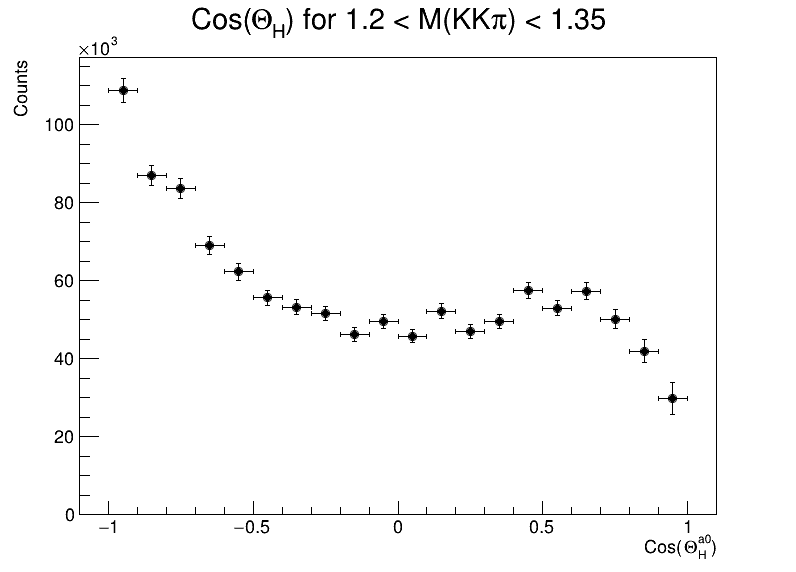

In [33]:
c1 = ROOT.TCanvas('c1', 'c1', 800, 600)

hist_full_range_data.SetTitle('Cos(#Theta_{H}) for 1.2 < M(KK#pi) < 1.35')
hist_full_range_data.GetXaxis().SetTitle('Cos(#Theta_{H}^{a0})')
hist_full_range_data.GetYaxis().SetTitle('Counts')
hist_full_range_data.SetLineColor(ROOT.kBlack)
hist_full_range_data.SetMarkerStyle(20)

hist_full_range_data.Draw('E1')
c1.Update()
c1.Draw()

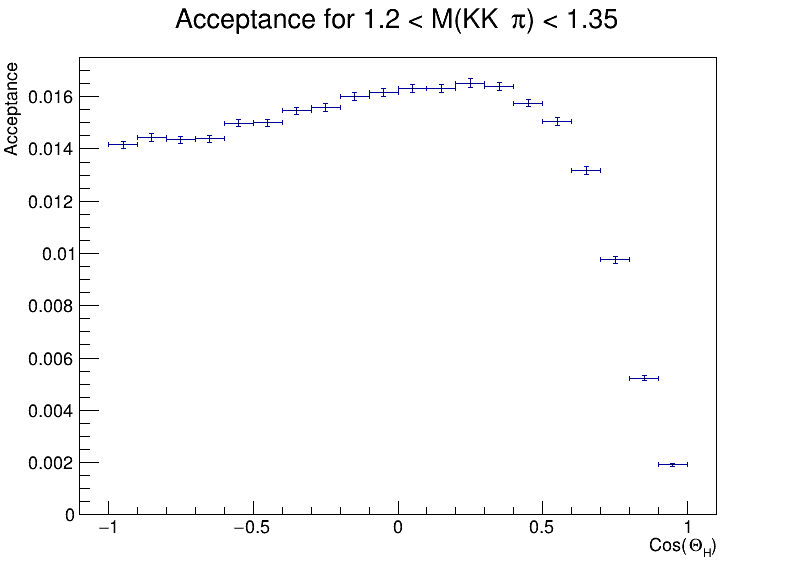

In [34]:
acceptance_full_range.SetTitle('Acceptance for 1.2 < M(KK#pi) < 1.35')
acceptance_full_range.GetXaxis().SetTitle('Cos(#Theta_{H})')
acceptance_full_range.GetYaxis().SetTitle('Acceptance')
acceptance_full_range.GetYaxis().SetTitleOffset(1.5)

acceptance_full_range.Draw('E1')
c1.Update()
c1.Draw()

In [35]:
good_acceptance_region = 'kk_helicity_costheta < 0.4999'
df_data = df_data.Filter(good_acceptance_region)
df_phasespace = df_phasespace.Filter(good_acceptance_region)
df_thrown = df_thrown.Filter(good_acceptance_region)

hist_1285_kk_data = df_data.Filter(signal_region).Histo1D(('1285_kk_costheta_data', 'Cos(#Theta_{H}^{a0}) for 1.2 < M(KK#pi) < 1.35', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()
hist_1285_kk_phasespace = df_phasespace.Filter(signal_region).Histo1D(('1285_kk_costheta_phasespace', '1285_kk_costheta_phasespace', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()
hist_1285_kk_thrown = df_thrown.Filter(signal_region).Histo1D(('1285_kk_costheta_thrown', '1285_kk_costheta_thrown', nbin, x_low, x_high), 'kk_helicity_costheta').GetValue()

In [36]:
hist_1285_kk_data.SetLineColor(ROOT.kBlack)
hist_1285_kk_phasespace.SetLineColor(ROOT.kRed)
hist_1285_kk_thrown.SetLineColor(ROOT.kViolet)

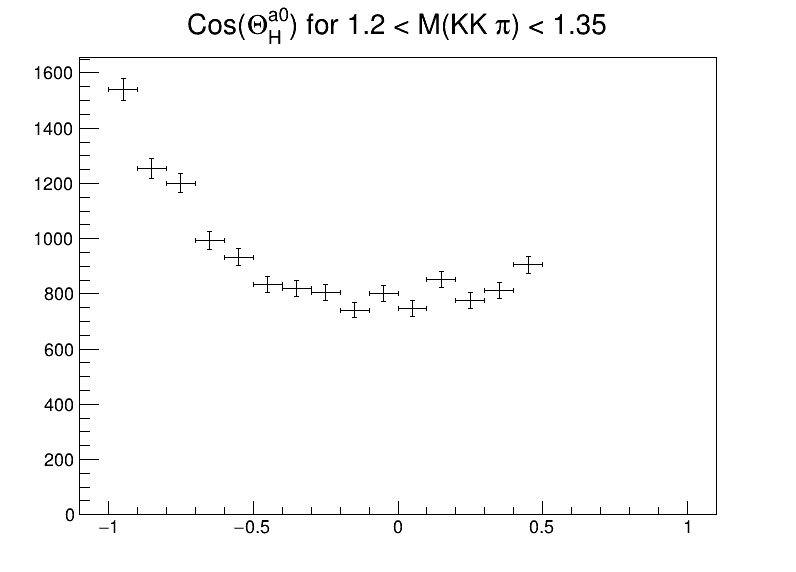

In [37]:
hist_1285_kk_data.Draw('E1')
# hist_1285_kk_thrown.Draw('E')
# hist_1285_kk_phasespace.Draw('E')
c1.Draw()

In [38]:
hist_1285_kk_data.Sumw2()
hist_1285_kk_phasespace.Sumw2()
hist_1285_kk_thrown.Sumw2()

acceptance = hist_1285_kk_phasespace.Clone('acceptance')
acceptance.Divide(hist_1285_kk_thrown)

for i in range(2, hist_1285_kk_data.GetNbinsX()):
    if hist_1285_kk_data.GetBinContent(i) <= 0:
        continue
    print(f'bin middle: {hist_1285_kk_data.GetBinCenter(i)} || data: {hist_1285_kk_data.GetBinContent(i)} || efficiency: {acceptance.GetBinContent(i)} || efficiency corrected: {hist_1285_kk_data.GetBinContent(i)/acceptance.GetBinContent(i)}')

hist_1285_kk_data.Divide(acceptance)


bin middle: -0.95 || data: 1539.0 || efficiency: 0.0141591240131262 || efficiency corrected: 108693.16481537076
bin middle: -0.8500000000000001 || data: 1255.0 || efficiency: 0.014446078022122635 || efficiency corrected: 86874.79038103635
bin middle: -0.75 || data: 1200.0 || efficiency: 0.01434366481060531 || efficiency corrected: 83660.62759029011
bin middle: -0.65 || data: 993.0 || efficiency: 0.014386711181159298 || efficiency corrected: 69022.02925296947
bin middle: -0.55 || data: 933.0 || efficiency: 0.014992030931581976 || efficiency corrected: 62233.062635600414
bin middle: -0.45 || data: 833.0 || efficiency: 0.014993077186896195 || efficiency corrected: 55558.97495999247
bin middle: -0.35000000000000003 || data: 821.0 || efficiency: 0.015453096835074674 || efficiency corrected: 53128.50937014352
bin middle: -0.25000000000000006 || data: 804.0 || efficiency: 0.015594205685169529 || efficiency corrected: 51557.61160471442
bin middle: -0.15000000000000008 || data: 741.0 || efficie

True

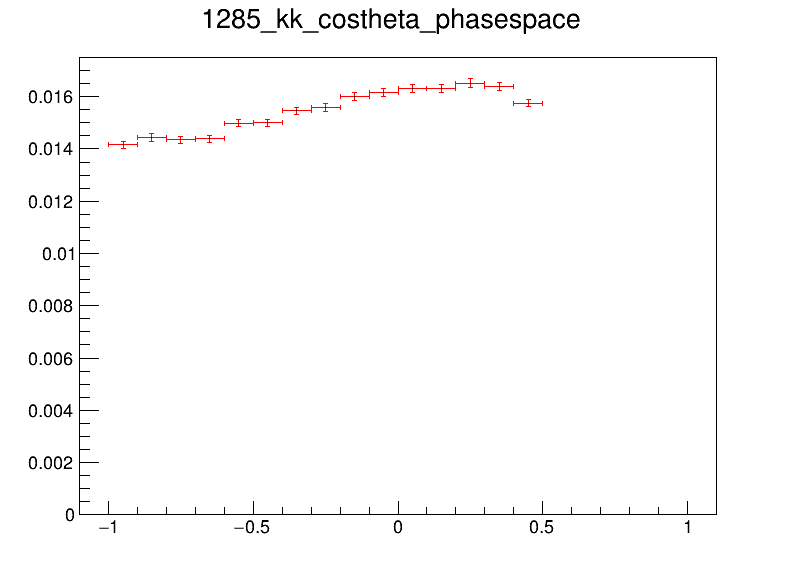

In [39]:
acceptance.Draw('E1')
c1.Draw()

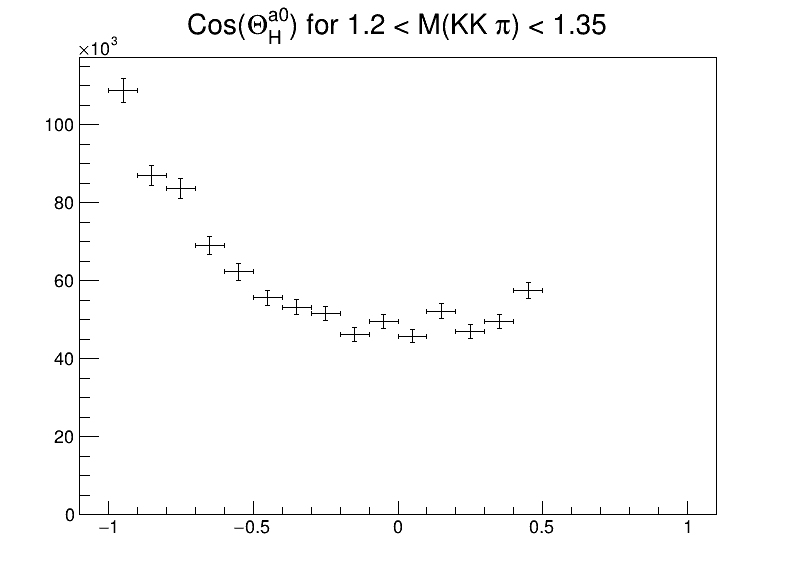

In [40]:
hist_1285_kk_data.Draw("E1")
c1.Draw()

In [41]:
func_eta = ROOT.TF1("func_eta", "[0]", -1, 1)
func_f1 = ROOT.TF1("func_f1", "[0]*cos(x)*cos(x) + [1]*sin(x)*sin(x)", -1, 1)

func_eta.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
func_f1.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))


func_eta.SetParameter(0, 600)
func_f1.SetParameter(0, -600)
func_f1.SetParameter(1, 200)

In [42]:
hist_1285_kk_data.Fit(func_eta, "BS+")
hist_1285_kk_data.Fit(func_f1, "BS+")

 FCN=741.784 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=7.36495e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.65667e+04   5.14776e+02   6.81230e+00   2.35766e-10
 FCN=56.2373 FROM MIGRAD    STATUS=CONVERGED      30 CALLS          31 TOTAL
                     EDM=1.06839e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.46627e+04   6.86802e+02   2.18685e+00   6.49832e-14
   2  p1           1.22764e+05   2.58014e+03   7.70349e+00   1.84473e-14


In [43]:
chi2_per_ndf_eta = func_eta.GetChisquare()/func_eta.GetNDF()
chi2_per_ndf_f1 = func_f1.GetChisquare()/func_f1.GetNDF()

print(f'chi2 per ndf for eta: {chi2_per_ndf_eta}')
print(f'chi2 per ndf for f1: {chi2_per_ndf_f1}')

chi2 per ndf for eta: 52.98455017802542
chi2 per ndf for f1: 4.325949609897023


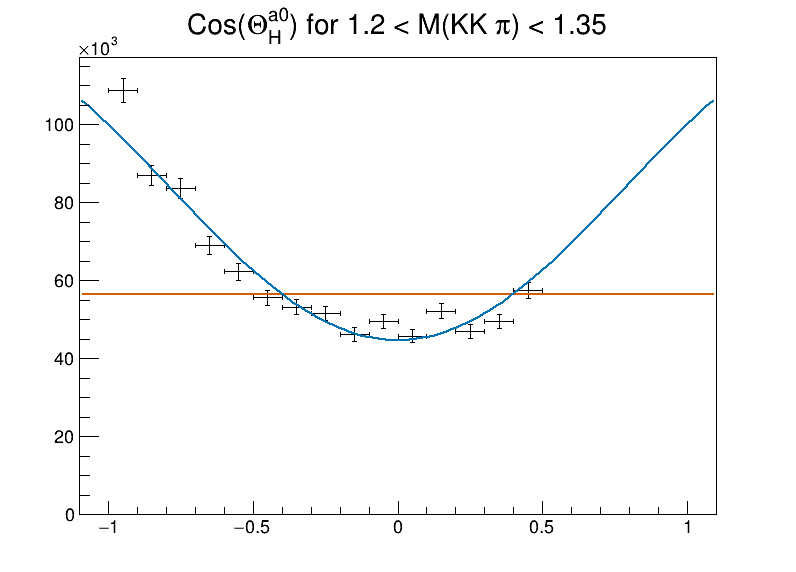

In [44]:
hist_1285_kk_data.Draw("E1")
c1.Draw()

In [45]:
hist2d = df_data.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

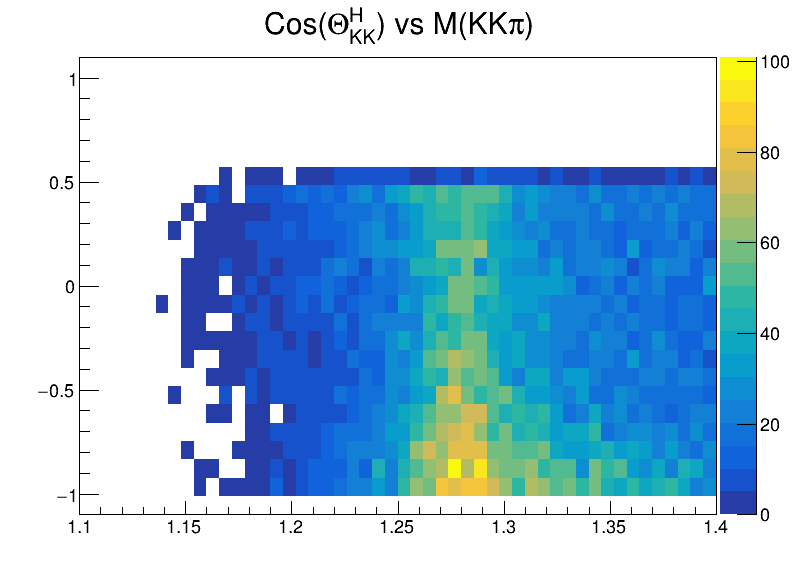

In [46]:
hist2d.Draw('COLZ')
c1.Draw()

In [47]:
hist_signal_costhets = df_phasespace.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_signal_kkpi = df_phasespace.Filter(f'{channel}_m < 1.35 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m').GetValue()
hist_signal_2d = df_phasespace.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

In [48]:
hist_thrown_costhets = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('costheta-kk_signal', 'Cos(#Theta^{H}_{KK})', 25, -1.1, 1.1), 'kk_helicity_costheta').GetValue()
hist_thrown_kkpi = df_thrown.Filter(f'{channel}_m < 1.32 && {channel}_m > 1.24').Histo1D(('kkpi_signal', 'M(KK#pi)', 50, 1.24, 1.35), f'{channel}_m').GetValue()
hist_thrown_2d = df_thrown.Filter(f'{channel}_m < 1.4 && {channel}_m > 1.1').Histo2D(('costheta-kk_vs_kkpi', 'Cos(#Theta^{H}_{KK}) vs M(KK#pi)', 50, 1.1, 1.4, 25, -1.1, 1.1), f'{channel}_m', 'kk_helicity_costheta').GetValue()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


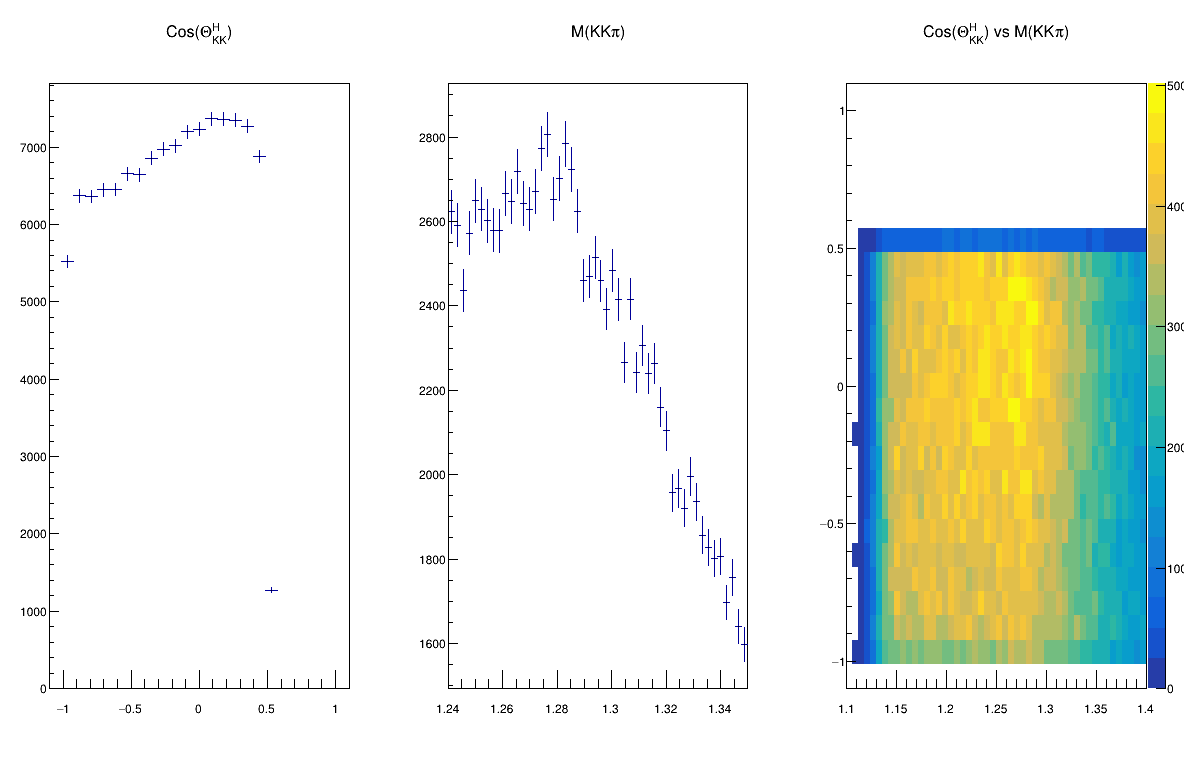

In [49]:
c2 = ROOT.TCanvas('c2', 'c2', 1200, 800)
c2.Divide(3, 1)

c2.cd(1)
hist_signal_costhets.Draw('E')
c2.cd(2)
hist_signal_kkpi.Draw('E')
c2.cd(3)
hist_signal_2d.Draw('COLZ')
c2.Draw()

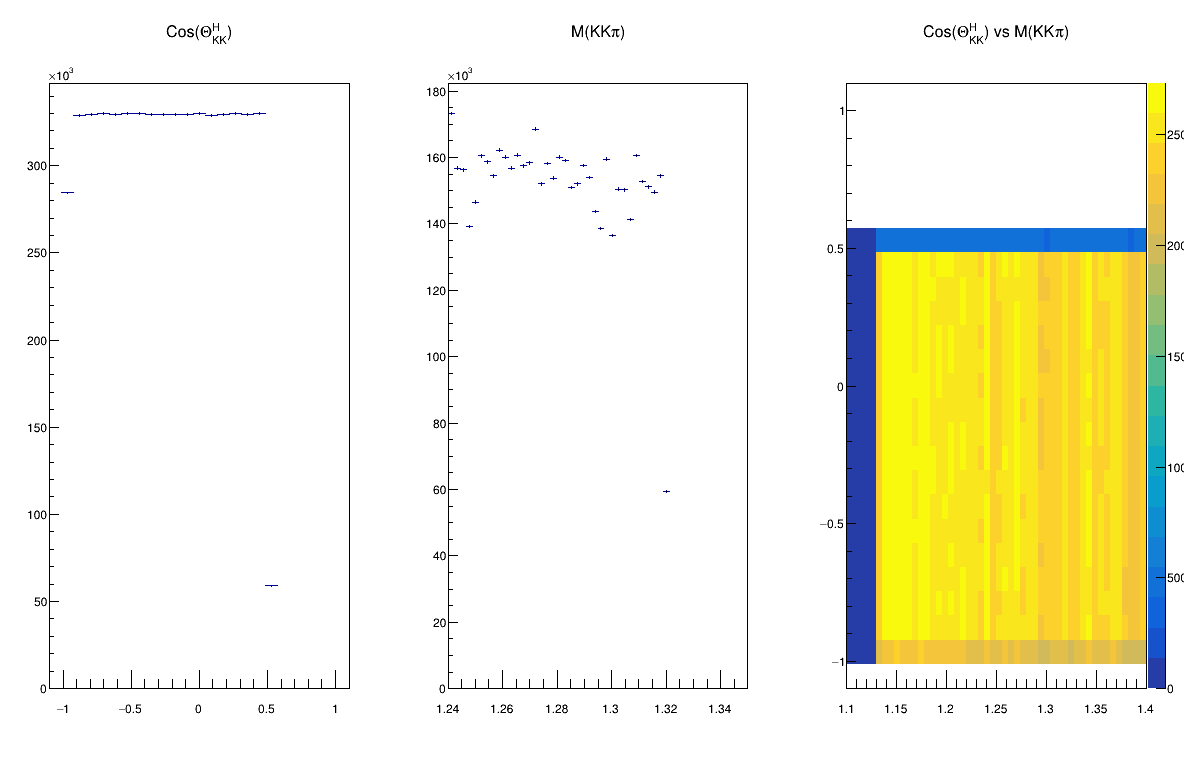

In [50]:
c2.cd(1)
hist_thrown_costhets.Draw('E')
c2.cd(2)
hist_thrown_kkpi.Draw('E')
c2.cd(3)
hist_thrown_2d.Draw('COLZ')
c2.Draw()

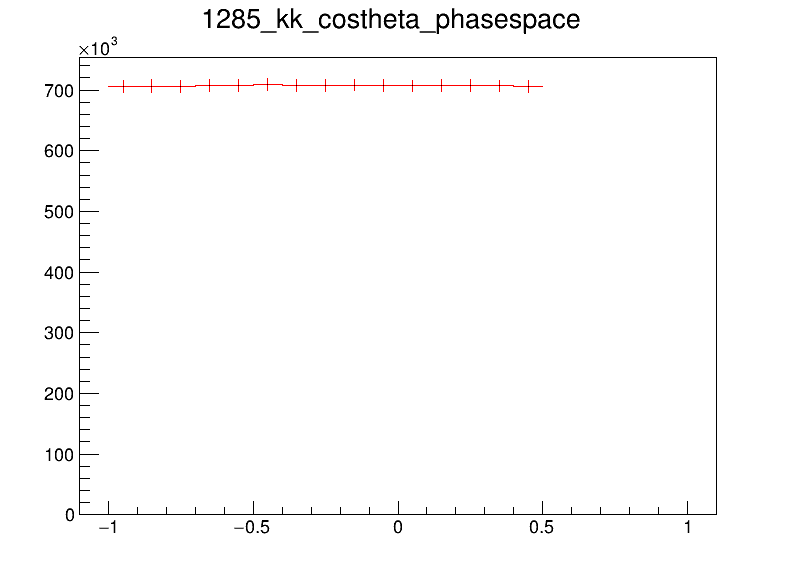

In [51]:
c1.cd()
hist_eff_test = hist_1285_kk_phasespace.Clone('eff_test')
hist_eff_test.Divide(acceptance)

hist_eff_test.Draw('E')
c1.Draw()